In [111]:
import pandas as pd
import re

from nltk.stem import WordNetLemmatizer

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
def normalize_ingreds(x: list[str]) -> str:
    skip_verbs = [
        "crushed","crumbles","ground","minced","powder","chopped",
        "sliced","grilled","boneless","skinless","steamed"]
    remove_verbs = lambda x: re.sub(r"|".join(skip_verbs),'', x)
    ingreds = list(map(remove_verbs, x))

    lemmatizer = WordNetLemmatizer()
    ingreds = [" ".join([lemmatizer.lemmatize(j) 
                    for j in i.lower().split(" ")]) 
                for i in ingreds]
    
    ingreds = [re.sub("[^A-Za-z ]", "", i) for i in ingreds]
    ingreds = [re.sub(" +", " ", i) for i in ingreds]
    ingreds = [i.strip().replace(" ", "_" ) for i in ingreds]

    return ",".join(ingreds)

In [113]:
yummly_df = pd.read_json("../assets/yummly.json")

yummly_df["ingredients"] = yummly_df["ingredients"].map(normalize_ingreds)
yummly_df = yummly_df[~yummly_df.duplicated(["cuisine", "ingredients"], keep="first")]
yummly_df

,id,cuisine,ingredients
0,10259,greek,"romaine_lettuce,black_olive,grape_tomato,garli..."
1,25693,southern_us,"plain_flour,pepper,salt,tomato,black_pepper,th..."
2,20130,filipino,"egg,pepper,salt,mayonaise,cooking_oil,green_ch..."
3,22213,indian,"water,vegetable_oil,wheat,salt"
4,13162,indian,"black_pepper,shallot,cornflour,cayenne_pepper,..."
...,...,...,...
39769,29109,irish,"light_brown_sugar,granulated_sugar,butter,warm..."
39770,11462,italian,"kraft_zesty_italian_dressing,purple_onion,broc..."
39771,2238,irish,"egg,citrus_fruit,raisin,sourdough_starter,flou..."
39772,41882,chinese,"chicken_thigh,garlic,white_rice,baking,corn_st..."


## Cusine Prediction using Linear SVC

In [114]:
y = yummly_df["cuisine"]
X = yummly_df.drop(["cuisine"], axis=1)

le = LabelEncoder()
y_transformed = le.fit_transform(yummly_df["cuisine"])

X_train, X_test , y_train, y_test = train_test_split(
    X, y_transformed, test_size=0.2)

In [115]:
preprocessor = ColumnTransformer(
    transformers=[
        ('vectorizer', TfidfVectorizer(ngram_range=(1,1), stop_words="english"), "ingredients")
    ])

clf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', LinearSVC(C=0.9, penalty='l2'))
])

cross_val_score(clf_pipe, X, y_transformed, cv=5)

array([0.78477823, 0.79319471, 0.78651544, 0.78563327, 0.79432892])

In [116]:
clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.65      0.73        92
           1       0.60      0.44      0.51       158
           2       0.79      0.69      0.74       306
           3       0.83      0.85      0.84       566
           4       0.72      0.62      0.66       156
           5       0.59      0.65      0.62       523
           6       0.78      0.68      0.73       244
           7       0.85      0.91      0.88       596
           8       0.67      0.53      0.59       144
           9       0.79      0.89      0.84      1514
          10       0.80      0.69      0.74       119
          11       0.87      0.75      0.81       306
          12       0.84      0.80      0.82       167
          13       0.91      0.91      0.91      1287
          14       0.81      0.76      0.78       160
          15       0.64      0.55      0.59        85
          16       0.72      0.79      0.75       857
   

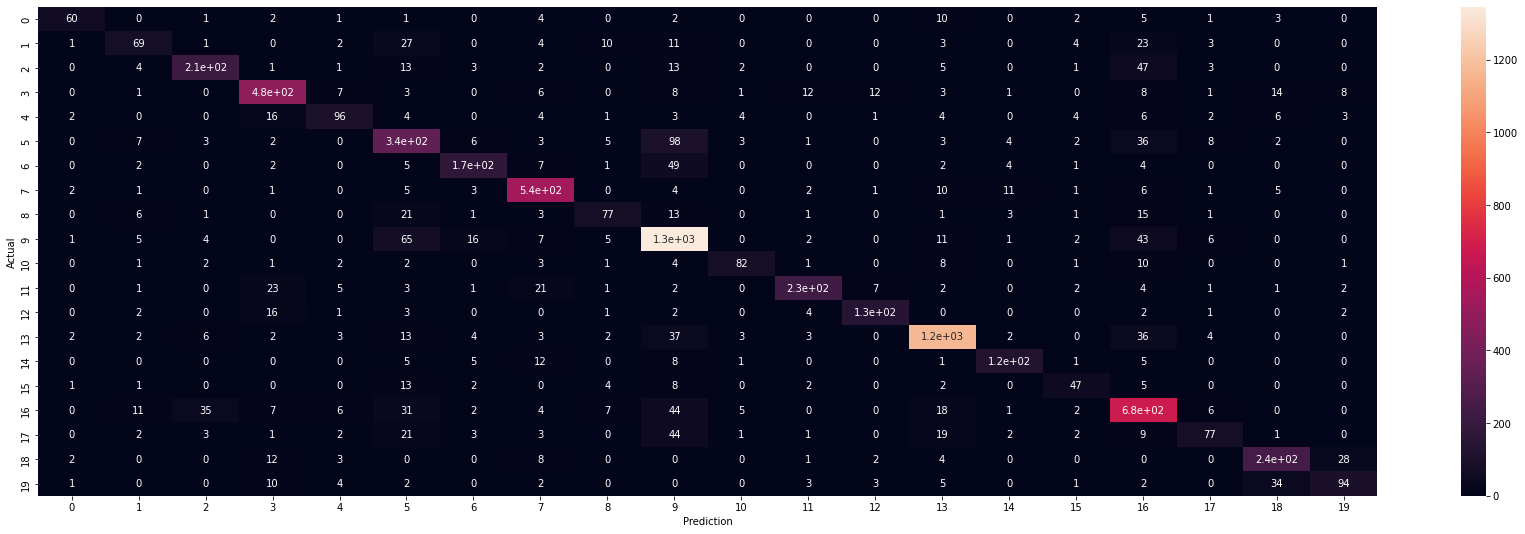

In [117]:
plt.figure(figsize=(30, 9))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# Similar dish prediction using K-Nearest Neighbors Algorithm

In [118]:
y = yummly_df["cuisine"]
X = yummly_df.drop(["cuisine"], axis=1)

le = LabelEncoder()
y_transformed = le.fit_transform(yummly_df["cuisine"])

X_train, X_test , y_train, y_test = train_test_split(
    X, y_transformed, test_size=0.2)

In [120]:
preprocessor = ColumnTransformer(
    transformers=[
        ('vectorizer', TfidfVectorizer(ngram_range=(1,1), stop_words="english"), "ingredients")
    ])

knn_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', KNeighborsClassifier(n_neighbors=14))
])

cross_val_score(knn_pipe, X, y_transformed, cv=5)

array([0.74584173, 0.74757404, 0.74240706, 0.74039067, 0.7463138 ])

In [121]:
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.48      0.45        71
           1       0.44      0.34      0.38       152
           2       0.75      0.65      0.70       313
           3       0.74      0.85      0.79       554
           4       0.69      0.56      0.62       161
           5       0.54      0.55      0.54       538
           6       0.82      0.61      0.70       238
           7       0.83      0.87      0.85       567
           8       0.59      0.37      0.45       139
           9       0.72      0.89      0.80      1584
          10       0.86      0.57      0.69       100
          11       0.81      0.67      0.73       273
          12       0.84      0.69      0.76       158
          13       0.86      0.91      0.88      1287
          14       0.83      0.67      0.74       163
          15       0.65      0.30      0.41       106
          16       0.68      0.74      0.71       859
   

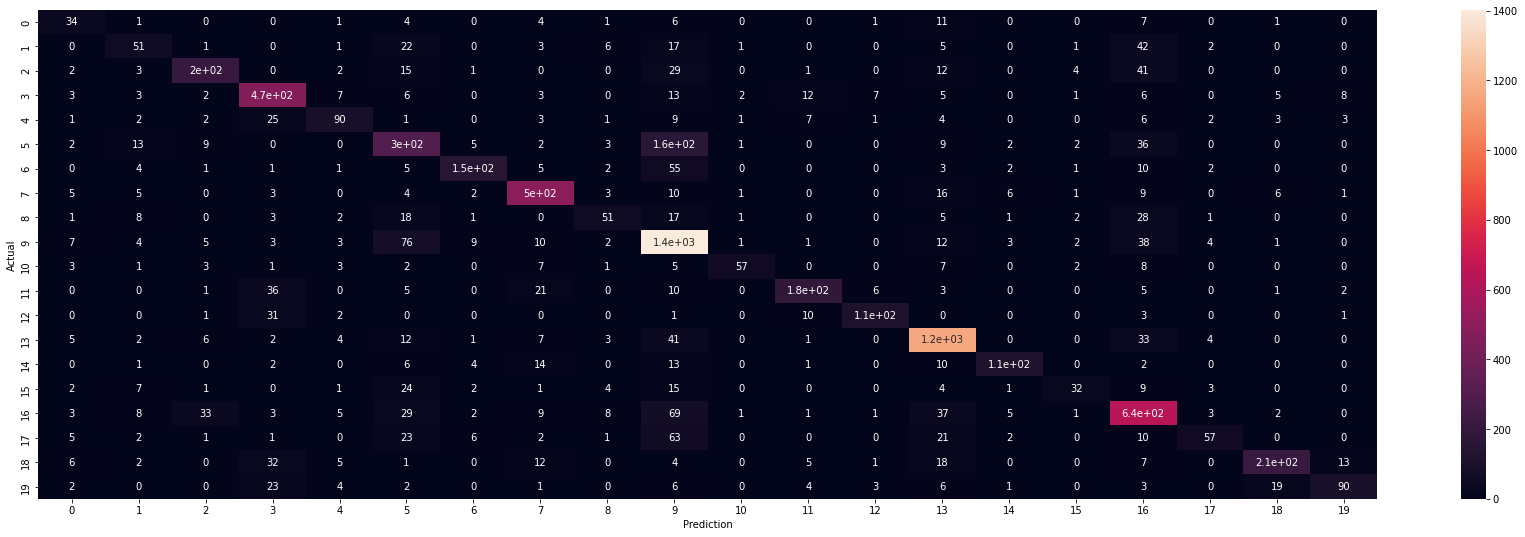

In [122]:
plt.figure(figsize=(30, 9))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# CLI Use-Case

#### Predicting cusine using LinearSVC

In [128]:
# input_ingreds = [
#     "chili powder",
#     "crushed red pepper flakes",
#     "garlic powder",
#     "sea salt",
#     "ground cumin",
#     "onion powder",
#     "dried oregano",
#     "ground black pepper",
#     "paprika"
# ]
input_ingreds = [
    "chili powder",
    "crushed red pepper flakes",
    "garlic powder",
    "sea salt",
    "ground cumin",
    "onion powder",
    "dried oregano",
    "ground black pepper",
    "paprika"
]

input_df = pd.DataFrame([normalize_ingreds(input_ingreds)], columns=["ingredients"])
input_df


,ingredients
0,"chili,red_pepper_flake,garlic,sea_salt,cumin,o..."


In [129]:
yummly_df[yummly_df["ingredients"]==normalize_ingreds(input_ingreds)]

,id,cuisine,ingredients
32,10276,mexican,"chili,red_pepper_flake,garlic,sea_salt,cumin,o..."


In [130]:
pred = clf_pipe.predict(input_df)
le.classes_[pred[0]]

'mexican'

#### Predicting K-nearest neighbors based on inputs using KNN

In [131]:
inp_vec = knn_pipe[0].transform(input_df)
dist, neighbors = knn_pipe[-1].kneighbors(X=inp_vec, n_neighbors=6)

In [132]:
neighbors_list = []
for neighbor_dish_id in neighbors[0]:
    neighbor_ingreds = X_train.iat[neighbor_dish_id, 1]

    neighbors_list.append([neighbor_dish_id, neighbor_ingreds])

neighbors_df = pd.DataFrame(neighbors_list, columns=["id", "ingredients"])

similarities = cosine_similarity(knn_pipe[0].transform(neighbors_df), inp_vec)
neighbors_df["similarities"] = similarities[:, 0]
neighbors_df

,id,ingredients,similarities
0,5996,"chili,red_pepper_flake,garlic,sea_salt,cumin,o...",1.000000
1,3773,"garlic,paprika,onion,dried_oregano,chili,red_p...",1.000000
2,21331,"chili,red_pepper_flake,black_pepper,sea_salt,d...",0.936979
3,28704,"garlic,red_pepper_flake,onion,dried_oregano,bl...",0.819989
4,6886,"onion,cumin,black_pepper,salt,garlic,paprika,c...",0.792796
5,3573,"garlic,red_pepper,black_pepper,paprika,cumin,c...",0.724220


In [135]:
input_df.iat[0, 0]

'chili,red_pepper_flake,garlic,sea_salt,cumin,onion,dried_oregano,black_pepper,paprika'